In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [2]:
from mmdet.core.visualization import imshow_det_bboxes
import numpy as np
from src.extensions.metrics.ot_cost import get_ot_cost, get_cmap
import matplotlib.pyplot as plt
%matplotlib inline

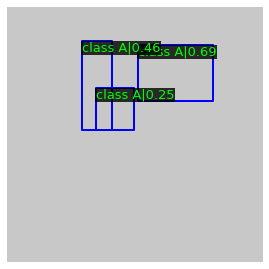

In [3]:
def get_random_bboxes(n, width, height, w_score=True):
    rng = np.random.default_rng()
    bboxes = []
    for _ in range(n):
        x = rng.integers(int(width*0.1), int(width * 0.9))
        y = rng.integers(int(height*0.1), int(height * 0.9))
        dx = rng.integers(int(width*0.1), width - x)
        dy = rng.integers(int(height*0.1), height - y)
        bboxes.append([x, y, x+dx, y+dy])
    if w_score:
        score = np.sort(rng.random(n))[::-1]
        return np.hstack([np.asarray(bboxes), score[:, None]])
    else:
        return np.asarray(bboxes)

im = np.ones((255, 255, 3), dtype=np.uint8)
im *= 200
h, w, _ = im.shape
bboxes=get_random_bboxes(3, w, h)
labels=np.asarray(np.zeros((3), dtype=np.uint8))
o_img = imshow_det_bboxes(im, bboxes, labels, class_names=["class A"], bbox_color="blue")

(-0.5, 1499.5, 254.5, -0.5)

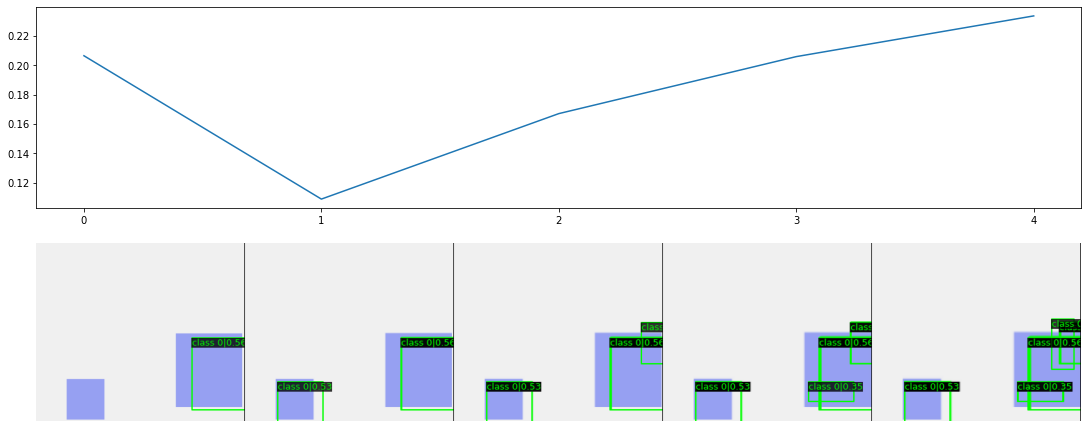

In [5]:
import matplotlib.gridspec as gridspec

img = np.ones((255, 300, 3), dtype=np.uint8) * 240
h, w = img.shape[:2]
gt_bboxes = get_random_bboxes(2, w, h)
gt_bboxes[:, -1] = 1
gt_bboxes = gt_bboxes
rng = np.random.default_rng()
bboxes = gt_bboxes[:,:4] + rng.integers(0, min(h, w)*0.1, (len(gt_bboxes), 4))
red_bboxes = get_random_bboxes(3, w, h, w_score=False)
bboxes = np.vstack([bboxes, red_bboxes])
score = np.sort(rng.random(len(bboxes)))[::-1]
bboxes = np.hstack([np.asarray(bboxes), score[:, None]])
# bboxes = rng.permutation(bboxes)

gt_color = np.asarray([61, 80, 245], dtype=np.uint8)
for x1, y1, x2, y2, _ in gt_bboxes:
    x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
    img[y1:y2, x1:x2, :] = 0.5 * img[y1:y2, x1:x2, :] + 0.5 * gt_color

cmap_f = lambda x, y: get_cmap(x, y, alpha=0.5, use_dummy=True)
imgs = []
otcs = []
for i in range(len(bboxes)):
    labels = np.zeros((i+1,), dtype=np.int64)
    img = imshow_det_bboxes(img, bboxes[:i+1], labels = labels, bbox_color="green", show=False)
    img[:, -1, :] = 0
    imgs.append(img)
    otc = get_ot_cost([gt_bboxes], [bboxes[:i+1]], cmap_f)
    otcs.append(otc)

fig = plt.figure(constrained_layout=True, figsize=(15, 6))
spec = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)
cost_axes = []
cost_ax = fig.add_subplot(spec[:2, :])   
cost_ax.plot(np.arange(len(otcs)), otcs)
cost_ax.set_xticks(range(len(imgs)))
cost_ax.set_xticklabels(range(len(imgs)))
    # cost_ax.set_ylim(0.1, 0.6)
    # cost_axes.append(cost_ax)

im_ax = fig.add_subplot(spec[2:, :])
im_ax.imshow(np.hstack(imgs))
im_ax.axis("off")

[222 239   0  17  34]


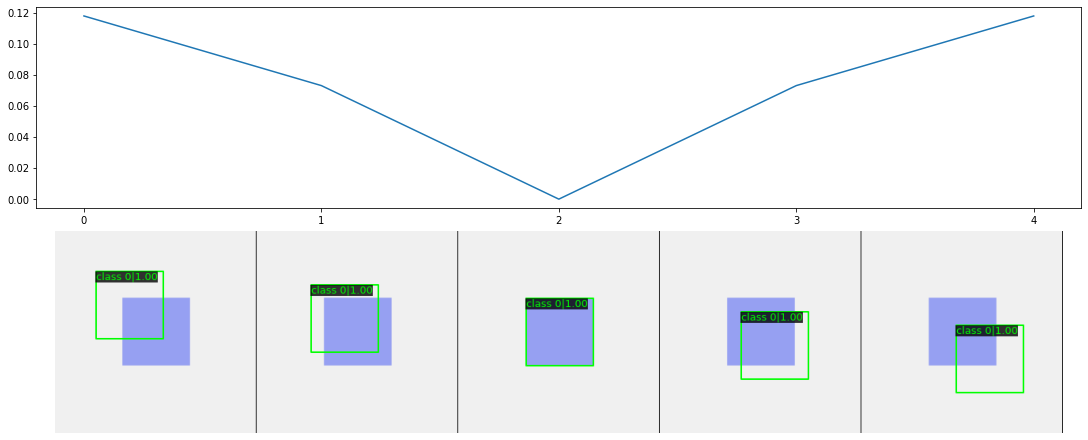

In [6]:
def toy_example():
    width, height = 255, 255
    x1, y1, x2, y2 = width/3, height/3, width*2/3, height*2/3
    gt_bboxes = np.asarray([[x1, y1, x2, y2, 1]]).astype(np.uint8)
    d = (x2-x1)/5
    offsets = np.linspace(-2*d, 2*d, 5).astype(np.uint8)
    print(offsets)
    bboxes = []
    for o in offsets:
        b = np.ones_like(gt_bboxes)
        b[0, :4] = gt_bboxes[0, :4]+o
        bboxes.append(b)
    
    bboxes = np.vstack(bboxes)

    img = np.ones((width, height, 3), dtype=np.uint8) * 240
    gt_color = np.asarray([61, 80, 245], dtype=np.uint8)
    for x1, y1, x2, y2, _ in gt_bboxes:
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        img[y1:y2, x1:x2, :] = 0.5 * img[y1:y2, x1:x2, :] + 0.5 * gt_color

    cmap_f = lambda x, y: get_cmap(x, y, alpha=0.5, use_dummy=True)
    imgs = []
    otcs = []
    for i in range(len(bboxes)):
        # labels = np.zeros((i+1,), dtype=np.int64)
        _img = imshow_det_bboxes(img, bboxes[i:i+1], labels = np.asarray([0]), bbox_color="green", show=False)
        _img[:, -1, :] = 0
        imgs.append(_img)
        otc = get_ot_cost([gt_bboxes], [bboxes[i:i+1]], cmap_f)
        otcs.append(otc)

    fig = plt.figure(constrained_layout=True, figsize=(15, 6))
    spec = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)

    cost_ax = fig.add_subplot(spec[:2, :])   
    cost_ax.plot(np.arange(len(otcs)), otcs)
    cost_ax.set_xticks(range(len(imgs)))
    cost_ax.set_xticklabels(range(len(imgs)))

    im_ax = fig.add_subplot(spec[2:, :])
    im_ax.imshow(np.hstack(imgs))
    im_ax.axis("off")
    
toy_example()